In [1]:
import numpy as np 
import pandas as pd 
import pickle

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
sys.path.append('..')

from utils.viz import viz 
from utils.model import *  
from utils.fig_fn import *
viz.get_style()

In [2]:
data_set = 'exp2'
models = ['rmPG_fea', 'caPG_fea', 'ecPG_fea']
method = 'map'
dpi = 300

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


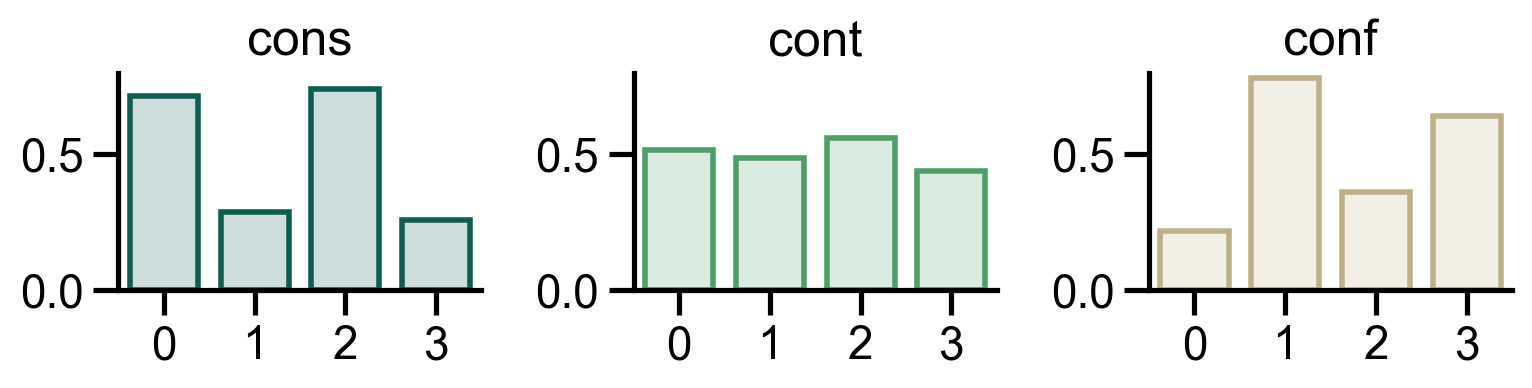

In [3]:
def sim_probe_bar(exp, agent_name, block_types):
    voi = {}
    for block_type in block_types:
        psi, rho, lmbda = 11, 4, .1
        fname = f'../simulations/{exp}/{agent_name}/simsubj-{block_type}_voi'
        fname += f'-alpha_psi={psi}-alpha_rho={rho}-lmbda={lmbda}.pkl'
        with open(fname, 'rb')as handle: voi[block_type] = pickle.load(handle)
    nr, nc = 1, len(block_types)
    fig, axs = plt.subplots(nr, nc, figsize=(8, 2.7))
    for b, block_type in enumerate(block_types):
        ax = axs[b]
        pol = voi[block_type]['pol'][59][4, :]
        sns.barplot(x=[0, 1, 2, 3], y=pol,
                        errorbar='se', linewidth=2, width=.75,
                        edgecolor=viz.Pal_type[b], 
                        facecolor=viz.Pal_type[b].tolist()+[.2],
                        color='w', ax=ax)
        ax.legend().remove()
        ax.set_box_aspect(.6)
        ax.set_title(f'{block_type}')
        ax.set_ylim([0, .8])
    fig.tight_layout()

sim_probe_bar(data_set, 'ecPG_fea_sim', block_types=['cons', 'cont', 'conf'])
plt.savefig(f'../figures/{data_set}/Fig6B_probPolicyBar_RDPG.pdf', dpi=dpi)

### Fig 5A: learning curve 

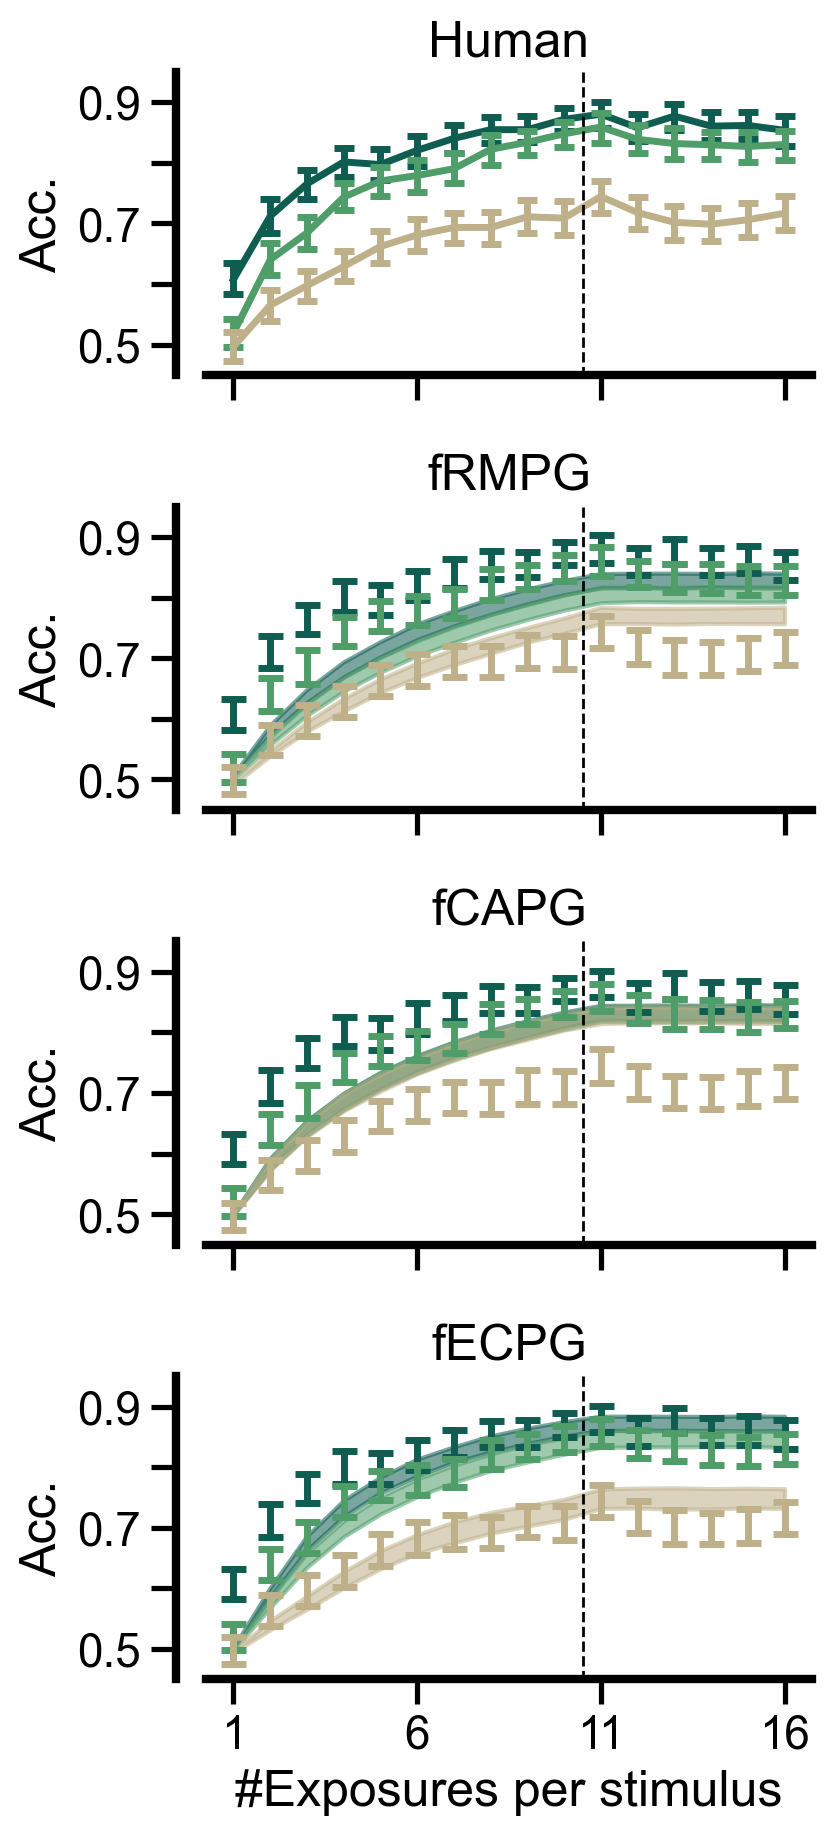

In [10]:
fig, ax = plt.subplots(len(models)+1, 1, figsize=(4.4, 9.5), sharex=True)
learning_curve_exp2(ax[0], get_sim_data(data_set, 'human', method=method), 
                    human=True)
ax[0].set_box_aspect(.5)
ax[0].set_title('Human')
for i, model in enumerate(models):
    learning_curve_exp2(ax[i+1], get_sim_data(data_set, model, method=method),
                        with_target_data_set=data_set)
    ax[i+1].set_box_aspect(.5)
    ax[i+1].set_title(eval(model).name)
fig.tight_layout()
plt.savefig(f'../figures/{data_set}/Fig6A_learnCurve.pdf', dpi=dpi)

### Fig5C: Human and model probe policy 

In [12]:
def viz_probe(axs, data_set, models, method, goodPoor=None):
    n = len(models) 
    for i, m in enumerate(models):
        if m == 'human':
            fname = f'{pth}/../data/{data_set}-human.csv'
            s = 1
        else:
            fname = f'{pth}/../simulations/{data_set}/{m}/sim-{method}.csv'
            s = 10
        data = pd.read_csv(fname, index_col=0)
        sel_data = data.query('group=="probe"').reset_index()
        for j, cond in enumerate(['cons', 'cont', 'conf']):
            ax = axs[i, j] if n > 1 else axs[j]
            sdata = sel_data.query(f'block_type=="{cond}"').copy()
            if goodPoor is not None: sdata = sdata.query(f'goodPoor=="good"').copy()
            # yvar = 'r' if m=='human' else 'acc' 
            if m!='human': sdata['r'] = sdata['acc']
            gdata = sdata.groupby(by=['sub_id', 'a', 'block_type']).count()['r'].reset_index()
            ptable = gdata.pivot_table(values='r', index='sub_id', columns='a').fillna(0) / (6*s)
            ptable.columns = [0, 1, 2, 3]
            ptable = ptable.reset_index()
            ptable = ptable.melt(id_vars='sub_id', value_vars=[0, 1, 2, 3]
                        ).rename(columns={'variable': 'a', 'value':'prop'})
        
            sns.stripplot(x='a', y='prop', data=ptable, 
                        color=viz.Pal_type[j], #dodge=True, 
                        edgecolor='none', size=2.8,
                        jitter=True, alpha=.3,
                        legend=False, zorder=2,
                        ax=ax)
            sns.violinplot(x='a', y='prop', data=ptable,
                        legend=False, alpha=.3, inner=None,
                        density_norm='width', edgecolor=[.8]*3,
                        color=viz.Pal_type[j],
                        ax=ax)
            sns.barplot(x='a', y='prop', data=ptable,
                        width=.75, errorbar=('ci', 95), lw=2.5,
                        edgecolor=viz.Pal_type[j], 
                        facecolor=viz.Pal_type[j].tolist()+[.2],
                        err_kws={'color': [.2, .2, .2], 'linewidth': 2.5},
                        capsize=.2,
                        color='w', ax=ax)
            ax.set_box_aspect(.9)
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_ylim([0, 1.1])
            if j==1: ax.set_title(eval(m).name)
            ax.spines['left'].set_position(('axes',-0.05))
            for pos in ['bottom', 'left']: ax.spines[pos].set_linewidth(2.5)
            ax.set_xticks(range(4))
            ax.set_xticklabels([r'$a_1$', r'$a_2$', r'$a_3$', r'$a_4$'])


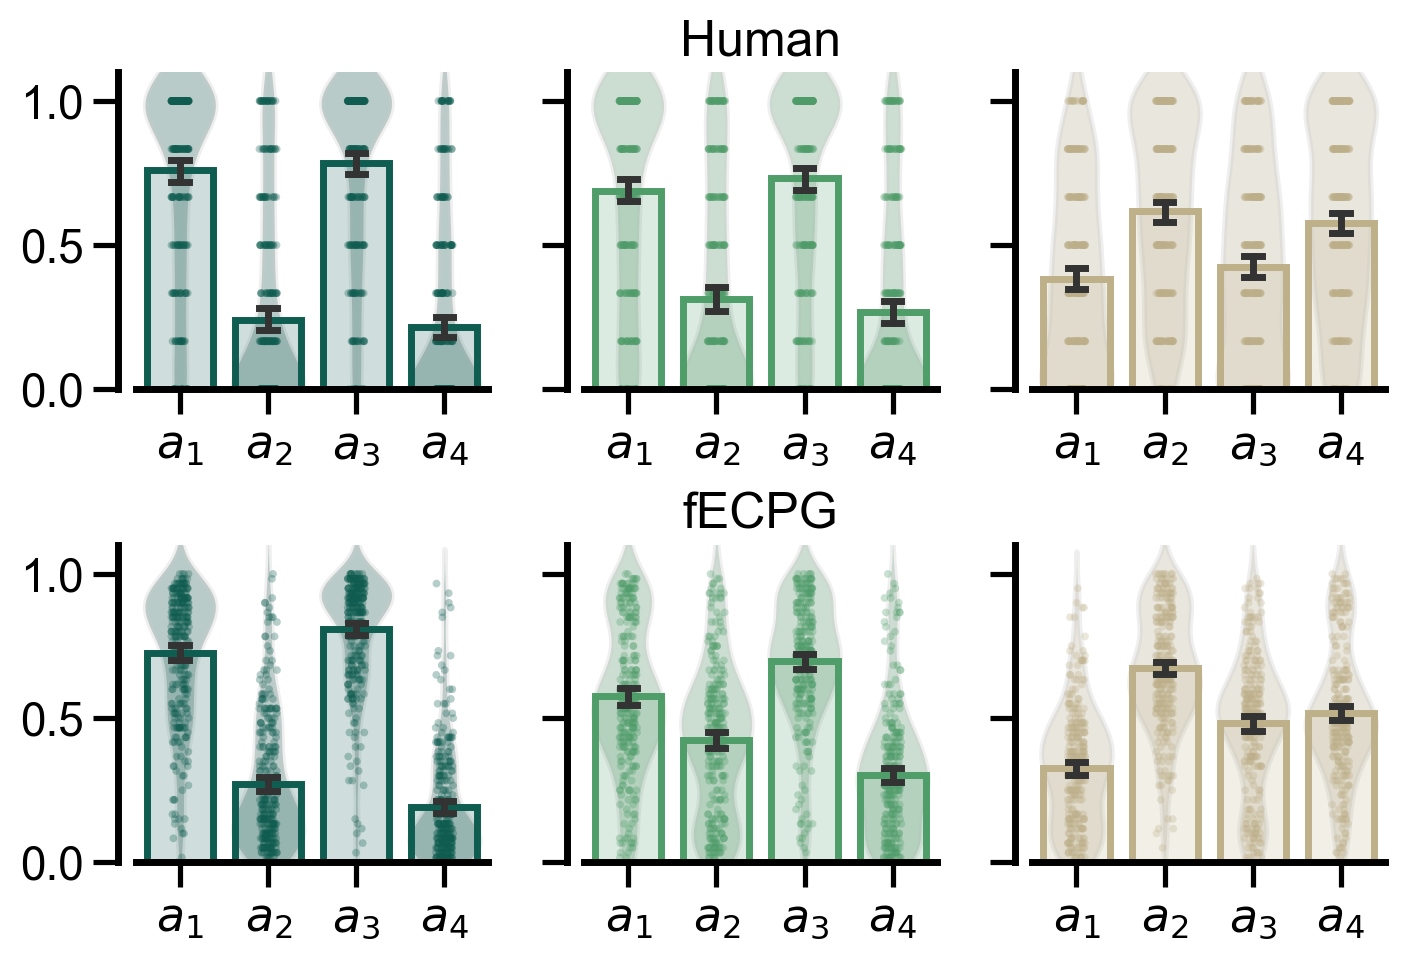

In [13]:
models = ['human', 'ecPG_fea']
fig, axs = plt.subplots(len(models), 3, figsize=(2.3*3.2, len(models)*2.5), sharey=True)
viz_probe(axs, 'exp2', models, method='map')
fig.tight_layout()
plt.savefig(f'../figures/{data_set}/Fig6B_probeData.pdf', dpi=dpi)

### Fig5D: correlation matrix 

In [14]:
def get_corr_matrix(data_set, models, method='mle', goodPoor=None):
    p_tables = {}
    conds = ['cons', 'cont', 'conf']
    for i, m in enumerate(['human']+models):
        if m == 'human':
            fname = f'{pth}/../data/{data_set}-human.csv'
            s = 1
        else:
            fname = f'{pth}/../simulations/{data_set}/{m}/sim-{method}.csv'
            s = 10
        data = pd.read_csv(fname, index_col=0)
        sel_data = data.query('group=="probe"').reset_index()
        pp = {}
        for j, cond in enumerate(['cons', 'cont', 'conf']):
            sdata = sel_data.query(f'block_type=="{cond}"').copy()
            if goodPoor is not None: sdata = sdata.query(f'goodPoor=="good"').copy() 
            if m!='human': sdata['r'] = sdata['acc']
            gdata = sdata.groupby(by=['sub_id', 'a', 'block_type']).count()['r'].reset_index()
            ptable = gdata.pivot_table(values='r', index='sub_id', columns='a').fillna(0) / (6*s)
            ptable.columns = [0, 1, 2, 3]
            ptable = ptable.reset_index()
            pp[cond] = ptable.sort_values(by='sub_id').loc[:, [0, 1, 2, 3]].values
        p_tables[m] = pp
    corr_data = {'corr': [], 'agent':[], 'cond':[]}
    for i, cond in enumerate(conds):
        y = p_tables['human'][cond][:, 0::2].reshape([-1])
        for m in models:
            x = p_tables[m][cond][:, 0::2].reshape([-1])
            corr_lm = pg.corr(x, y, method='spearman')
            #print(corr_lm)
            r = corr_lm["r"][0]
            corr_data['corr'].append(r)
            corr_data['agent'].append(m)
            corr_data['cond'].append(cond)
    corr_data = pd.DataFrame.from_dict(corr_data).pivot_table(
                    values='corr', index='cond', columns='agent'
                    ).loc[['cons', 'cont', 'conf'], models]
    return corr_data

In [21]:
def show_corr_mat(ax, corr_data, models=['ecPG_fea', 'l2PG_fea', 'caPG_fea', 'rmPG_fea'], 
                  font_scale=50,
                  marker_scale=5500):
    block_types = ['conf', 'cont', 'cons']
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
                        'cool_warm',   [viz.new_blue, viz.lRed*.9, viz.new_red])
    norm = plt.Normalize(0, .75)
    f_mean = corr_data.values.mean()*font_scale
    for i, block_type in enumerate(block_types):
        for j, model in enumerate(models):
            color = corr_data.loc[block_type, model]
            size  = corr_data.loc[block_type, model]*marker_scale
            ax.scatter(j, i, color=cmap(norm(color)), s=size, marker='s')
            fs = color*font_scale
            f_norm = np.sign(fs - f_mean)*np.abs(fs- f_mean)**(2/3) + f_mean
            ax.text(j-f_norm/85, i-f_norm/200, f'{color:.2f}', fontsize=f_norm)

    ax.set_aspect('equal')
    ax.set_xticks(np.arange(len(models)), minor=False)
    ax.set_xticklabels([eval(m).name for m in models])
    ax.set_yticks(np.arange(len(block_types)), minor=False)
    ax.set_yticklabels(['Conflict', 'Control', 'Consistent'])
    ax.set_xlim([-.5, len(models)-.5])
    ax.set_ylim([-.5, len(block_types)-.5])
    ax.spines
    gray = [.2]*3
    for pos in ['bottom', 'top', 'left', 'right']: 
        ax.spines[pos].set_color(gray)
        ax.spines[pos].set_visible(True)
        ax.spines[pos].set_linewidth(3)
    for xy in ['x', 'y']: ax.tick_params(axis=xy, colors=gray, which='major')
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=.75)
    fig.tight_layout()


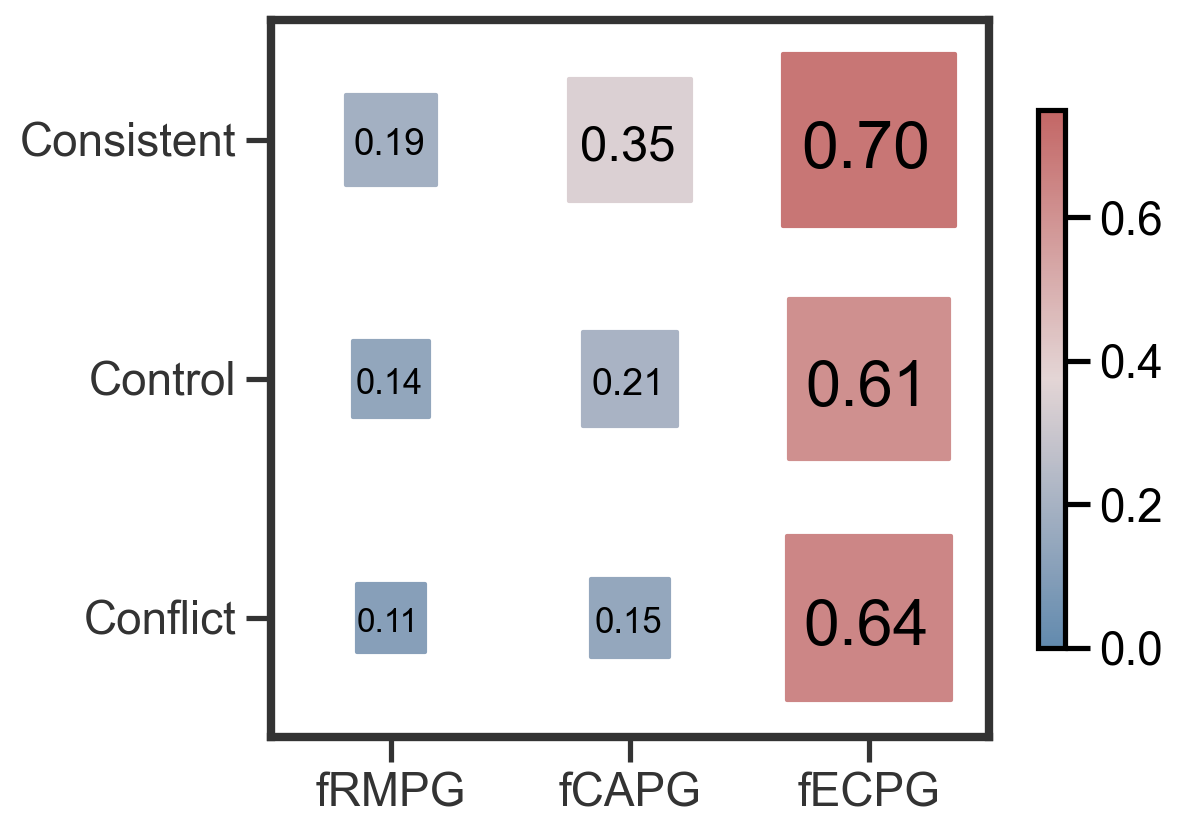

In [25]:
models = ['rmPG_fea', 'caPG_fea', 'ecPG_fea']
corr_data = get_corr_matrix('exp2', models=models, method='map')
fig, ax = plt.subplots(figsize=(1.8+1.5*len(models), 4.5))
show_corr_mat(ax, corr_data, models=models, font_scale=50)
plt.savefig(f'../figures/{data_set}/Fig6C_corr_mat.pdf', dpi=dpi)